In [1]:
!pip install statistics

  Preparing metadata (setup.py) ... done
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7436 sha256=a2be3d34c45e0cac03f2311a4e0430c4abc18eb8bbe15fa0f8ffb0020f42c162
  Stored in directory: /Users/davidntim/Library/Caches/pip/wheels/a7/30/34/fceae1c718a4e749dd51f479c5720c0671519887e824915e90
Successfully built statistics


In [2]:
import pandas as pd #data manipulation
from rdkit import Chem #Chemistry
from rdkit.Chem import Descriptors
import numpy as np #matrix algebra
#from lightgbm import LGBMRegressor, plot_importance #LightGBM models
from sklearn.model_selection import train_test_split #ML trainining
from sklearn.metrics import r2_score, mean_squared_error #ML stats
import seaborn as sns #Plotting
import matplotlib.pyplot as plt
#from yellowbrick.regressor import prediction_error, ResidualsPlot

In [3]:
dfTrain = pd.read_csv("training_data.csv")
dfTest = pd.read_csv("test_data.csv")

In [4]:
smiles_stringsTrain = dfTrain['SMILES'].tolist()
smiles_stringsTest = dfTest['SMILES'].tolist()

In [5]:
smilesTrain = [Chem.MolFromSmiles(mol) for mol in smiles_stringsTrain]
smilesTest = [Chem.MolFromSmiles(mol) for mol in smiles_stringsTest]

In [6]:
descrsTrain = [Descriptors.CalcMolDescriptors(mol) for mol in smilesTrain]
descrsTest = [Descriptors.CalcMolDescriptors(mol) for mol in smilesTest]
df2Train = pd.DataFrame(descrsTrain)
df2Test = pd.DataFrame(descrsTest)

In [7]:
train_X = df2Train.dropna(axis = 1)
train_y = dfTrain.pIC50
test_X = df2Test.dropna(axis = 1)
test_y = dfTest.pIC50

In [8]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [16]:
regressor = RandomForestRegressor(n_estimators=10, random_state=1)
#classifier = RandomForestClassifier(n_estimators=10, random_state=0)

from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 10)

scores = cross_val_score(regressor, train_X, train_y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores)) 

Cross Validation Scores:  [0.62710839 0.69075528 0.65245987 0.64020414 0.60159779 0.62600194
 0.59390489 0.64664854 0.59047069 0.36111737]
Average CV Score:  0.6030268903112016
Number of CV Scores used in Average:  10


In [17]:
# Initial parameters for RF hyperparameter tuning:

hyper_cv = 5

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 300, num = 10)]

# Number of features to consider at every split
#max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Collect all hyperparameter values:
init_param_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

# Set up hyperparameter tuning using a random grid search over
# different combinations of hyperparameters:
rf = RandomizedSearchCV(estimator = RandomForestRegressor(),
                        param_distributions = init_param_grid,
                        n_iter = 10,
                        cv = hyper_cv,
                        refit = True,
                        verbose = 1,
                        n_jobs = 1)

# Train RF model:
rf.fit(train_X, train_y)

rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


NameError: name 'rf_random' is not defined

In [18]:
rf.best_params_

{'n_estimators': 237,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 30,
 'bootstrap': True}

In [22]:
rf.best_estimator_

RandomForestRegressor(max_depth=30, min_samples_split=5, n_estimators=237)

In [8]:
# Fit the regressor with x and y data
regressor.fit(train_X, train_y)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [23]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
    
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_X, train_y)
base_accuracy = evaluate(base_model, test_X, test_y)
best_random = rf.best_estimator_
random_accuracy = evaluate(best_random, test_X, test_y)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- BCUT2D_CHGHI
- BCUT2D_CHGLO
- BCUT2D_LOGPHI
- BCUT2D_LOGPLOW
- BCUT2D_MRHI
- ...


In [10]:

# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score
 
# Making predictions on the same data or new data
predictions = regressor.predict(test_X)
 
# Evaluating the model
mse = mean_squared_error(test_y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(test_y, predictions)
print(f'R-squared: {r2}')


Out-of-Bag Score: 0.33529732893710884
Mean Squared Error: 1.5245919335016833
R-squared: -0.1095827810652985


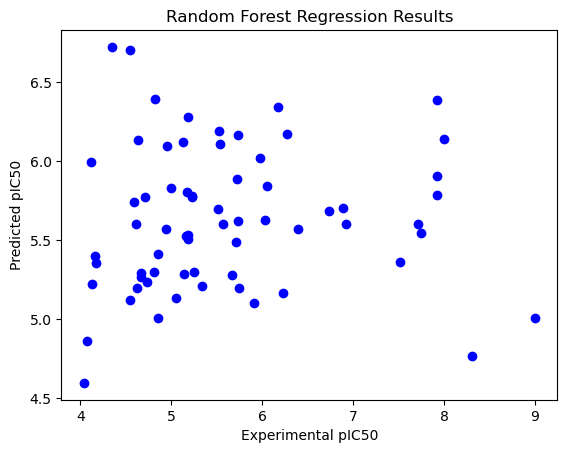

In [15]:
plt.scatter(test_y, predictions, color='blue') #plotting real points
#plt.plot(test_X, regressor.predict(test_X), color = 'green')
#plt.plot(X_grid, regressor.predict(X_grid),color='green') #plotting for predict points
   
plt.title("Random Forest Regression Results")
plt.xlabel('Experimental pIC50')
plt.ylabel('Predicted pIC50')
plt.show()

In [12]:
'''
# Use trained RF model to predict y data for the test set:
y_pred = rf.predict(test_X)

# Assess performace of model based on predictions:

# Coefficient of determination
r2 = r2_score(test_y, y_pred)
# Root mean squared error
rmsd = mean_squared_error(test_y, y_pred)**0.5
# Bias
bias = np.mean(y_pred - test_y)
# Standard deviation of the error of prediction
sdep = np.mean(((y_pred - test_y) - np.mean(y_pred - test_y))**2)**0.5
'''

In [13]:
'''
print(r2)
print(rmsd)
print(bias)
print(sdep)
'''

0.06301706754527048
1.1346522915630484
0.1254118788439176
1.1277001744231998
